In [1]:
#Author     : Fan Li
#Update Date: 10/12/2022
#Version    : 4.0

#Intrusion Detection System Using Machine Learning (CatBoost)

#Original Data (cic ids 2017)

#Synthenic Minority Over-sampling Technique (SMOTE)

#hardware
#12vCPUs | 48GiB | c7.3xlarge.4

#System
#Ubuntu 20.04 server 64bit

In [2]:
#1. Loading Module
#basic
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import gc    #memory manage

import math
import numpy as np
import pandas as pd

#draw figure
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

#Feature Selection

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

#metrics

from sklearn import model_selection,feature_selection,utils,ensemble,metrics
from catboost import CatBoostClassifier

#over-sampling and under sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

#time
from time import time
import datetime

#ROC   09/12/2022 LiFan
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [3]:
#2. Reading Dataset
base_path="../../data/"
# Monday benign
f1_path=base_path+"Monday-WorkingHours.pcap_ISCX.csv"
f1=pd.read_csv(f1_path)
#Tuesday benign
f2_path=base_path+"Tuesday-WorkingHours.pcap_ISCX.csv"
f2=pd.read_csv(f2_path)
#Wed benign
f3_path=base_path+"Wednesday-workingHours.pcap_ISCX.csv"
f3=pd.read_csv(f3_path)
#Thur WebAttack
f4_path1=base_path+"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
f41=pd.read_csv(f4_path1)
f4_path2=base_path+"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f42=pd.read_csv(f4_path2)
#Fri Benign DDos PortScan
f5_path1=base_path+"Friday-WorkingHours-Morning.pcap_ISCX.csv"
f51=pd.read_csv(f5_path1)

f5_path2=base_path+"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
f52=pd.read_csv(f5_path2)

f5_path3=base_path+"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f53=pd.read_csv(f5_path3)

In [4]:
data=pd.concat((f1,f2,f3,f41,f42,f51,f52,f53))
data.reset_index(inplace=True,drop=True) # duplicate index exist, reset index
data.shape

(2830743, 79)

In [5]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
# too few samples in some subclasses of Web Attack, and they are combined into one class.
#Tuesday Brute Force
data[' Label'].replace("FTP-Patator","BruteForce",inplace=True,regex=True)
data[' Label'].replace("SSH-Patator","BruteForce",inplace=True,regex=True)
#Thursday Web Attack
data[' Label'].replace("Web Attack .*","Web Attack",inplace=True,regex=True)
#DoS 
data[' Label'].replace("DoS .*","DoS",inplace=True,regex=True)
data[' Label'].replace("DDoS","DoS",inplace=True,regex=True)

In [7]:
target_count_new=data[' Label'].value_counts(0)
target_count_new

BENIGN          2273097
DoS              380688
PortScan         158930
BruteForce        13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [8]:
labels_new,values_new=zip(*sorted(target_count_new.items()))

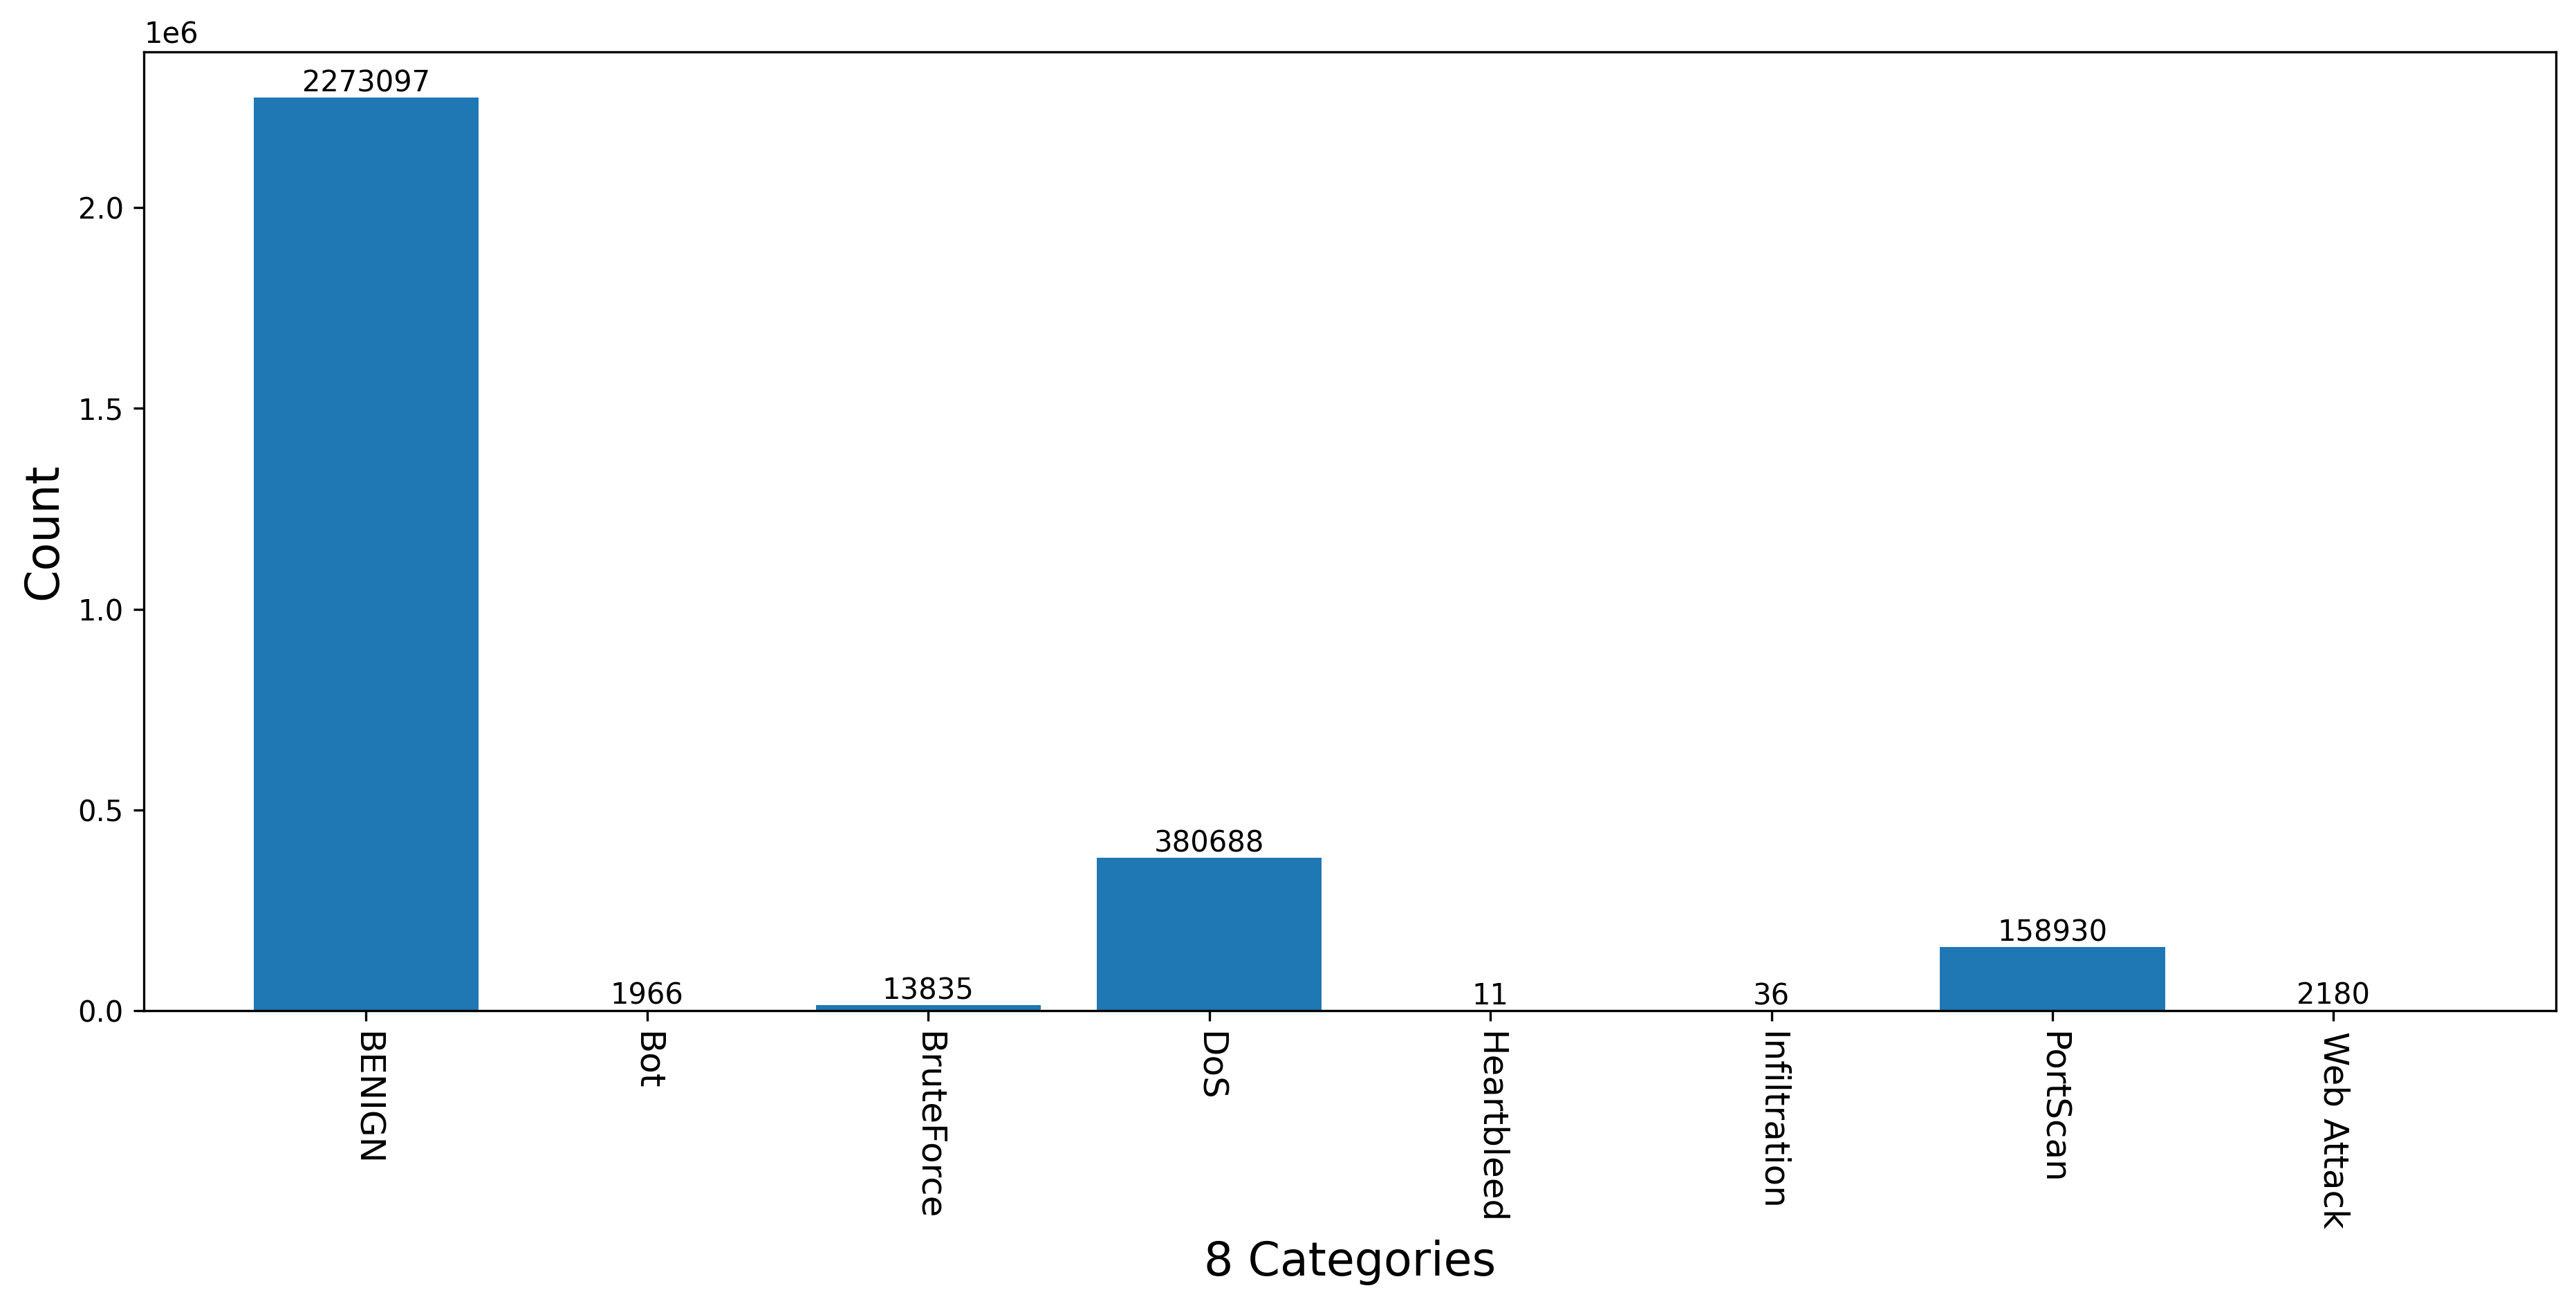

In [9]:
plt.figure(dpi=300,figsize=(15,6))
plt.bar(labels_new,values_new)
for x_new,y_new in zip(labels_new,values_new):
    plt.text(x_new,y_new,y_new,ha="center",va="bottom")
plt.xticks(fontsize=12,rotation=-90)
plt.xlabel("8 Categories",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.show()

In [10]:
#3. Preprocessing
#3.1 remove useless data
#remove duplicate row
data=data.drop_duplicates()
#remove rows with null value and infinite value
data=data.replace(np.inf,np.nan)
data=data.dropna()

In [11]:
data[' Label'].value_counts()

BENIGN          2072476
DoS              321759
PortScan          90694
BruteForce         9150
Web Attack         2143
Bot                1948
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [12]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print(Counter(y))

Counter({'BENIGN': 2072476, 'DoS': 321759, 'PortScan': 90694, 'BruteForce': 9150, 'Web Attack': 2143, 'Bot': 1948, 'Infiltration': 36, 'Heartbleed': 11})


In [13]:
#Label Encoding
le=LabelEncoder()
le=le.fit(y)
le.classes_
y=le.transform(y)
print(Counter(y))

Counter({0: 2072476, 3: 321759, 6: 90694, 2: 9150, 7: 2143, 1: 1948, 5: 36, 4: 11})


In [14]:
#Ram Clean
del data
gc.collect()

3692

In [15]:
#3.2 Splitting data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.33,random_state=123456)

In [16]:
print(Counter(y_train))

Counter({0: 1388615, 3: 215467, 6: 60860, 2: 6100, 7: 1440, 1: 1293, 5: 20, 4: 10})


In [17]:
#3.3 SMOTE
time0=time()
sm=SMOTE(k_neighbors=9,random_state=42,n_jobs=-1)
X_train,y_train=sm.fit_resample(X_train,y_train)

In [18]:
print("Time of SMOTE : {:.3f} s".format(time()-time0))

Time of SMOTE : 73.767 s


In [19]:
print(Counter(y_train))

Counter({0: 1388615, 6: 1388615, 3: 1388615, 1: 1388615, 2: 1388615, 7: 1388615, 4: 1388615, 5: 1388615})


In [20]:
#4. Training
clf=CatBoostClassifier(random_state=12345)

In [21]:
time1=time()
clf.fit(X_train,y_train)
print("Time of Training : {:.3f} s".format(time()-time1))

Learning rate set to 0.127248
0:	learn: 1.3902873	total: 3.94s	remaining: 1h 5m 33s
1:	learn: 1.0891581	total: 7.93s	remaining: 1h 5m 55s
2:	learn: 0.9032698	total: 11.9s	remaining: 1h 5m 49s
3:	learn: 0.7708475	total: 15.3s	remaining: 1h 3m 37s
4:	learn: 0.6595119	total: 19.3s	remaining: 1h 4m 9s
5:	learn: 0.5719039	total: 23.3s	remaining: 1h 4m 22s
6:	learn: 0.5012332	total: 27.2s	remaining: 1h 4m 12s
7:	learn: 0.4441756	total: 31s	remaining: 1h 4m 1s
8:	learn: 0.3973541	total: 34.8s	remaining: 1h 3m 47s
9:	learn: 0.3522920	total: 39.1s	remaining: 1h 4m 29s
10:	learn: 0.3140681	total: 43.2s	remaining: 1h 4m 47s
11:	learn: 0.2809480	total: 47s	remaining: 1h 4m 30s
12:	learn: 0.2536945	total: 51.3s	remaining: 1h 4m 57s
13:	learn: 0.2297534	total: 54.9s	remaining: 1h 4m 27s
14:	learn: 0.2071496	total: 59s	remaining: 1h 4m 33s
15:	learn: 0.1885513	total: 1m 2s	remaining: 1h 4m 20s
16:	learn: 0.1733749	total: 1m 6s	remaining: 1h 4m 24s
17:	learn: 0.1575933	total: 1m 10s	remaining: 1h 4m 3

151:	learn: 0.0052233	total: 9m 1s	remaining: 50m 21s
152:	learn: 0.0051834	total: 9m 5s	remaining: 50m 17s
153:	learn: 0.0051315	total: 9m 8s	remaining: 50m 11s
154:	learn: 0.0050898	total: 9m 11s	remaining: 50m 7s
155:	learn: 0.0050540	total: 9m 14s	remaining: 50m
156:	learn: 0.0050262	total: 9m 17s	remaining: 49m 55s
157:	learn: 0.0049916	total: 9m 20s	remaining: 49m 48s
158:	learn: 0.0049500	total: 9m 23s	remaining: 49m 42s
159:	learn: 0.0049025	total: 9m 28s	remaining: 49m 44s
160:	learn: 0.0048669	total: 9m 31s	remaining: 49m 38s
161:	learn: 0.0048515	total: 9m 34s	remaining: 49m 30s
162:	learn: 0.0047973	total: 9m 38s	remaining: 49m 28s
163:	learn: 0.0047399	total: 9m 40s	remaining: 49m 20s
164:	learn: 0.0047037	total: 9m 44s	remaining: 49m 18s
165:	learn: 0.0046806	total: 9m 47s	remaining: 49m 11s
166:	learn: 0.0046565	total: 9m 50s	remaining: 49m 7s
167:	learn: 0.0046228	total: 9m 54s	remaining: 49m 1s
168:	learn: 0.0045931	total: 9m 57s	remaining: 49m
169:	learn: 0.0045417	to

299:	learn: 0.0025714	total: 17m 26s	remaining: 40m 42s
300:	learn: 0.0025631	total: 17m 30s	remaining: 40m 39s
301:	learn: 0.0025565	total: 17m 34s	remaining: 40m 36s
302:	learn: 0.0025494	total: 17m 37s	remaining: 40m 33s
303:	learn: 0.0025421	total: 17m 41s	remaining: 40m 29s
304:	learn: 0.0025379	total: 17m 44s	remaining: 40m 25s
305:	learn: 0.0025347	total: 17m 47s	remaining: 40m 20s
306:	learn: 0.0025282	total: 17m 50s	remaining: 40m 17s
307:	learn: 0.0025214	total: 17m 54s	remaining: 40m 13s
308:	learn: 0.0025135	total: 17m 57s	remaining: 40m 9s
309:	learn: 0.0025106	total: 17m 59s	remaining: 40m 3s
310:	learn: 0.0025068	total: 18m 3s	remaining: 39m 59s
311:	learn: 0.0025007	total: 18m 6s	remaining: 39m 56s
312:	learn: 0.0024858	total: 18m 11s	remaining: 39m 55s
313:	learn: 0.0024753	total: 18m 14s	remaining: 39m 51s
314:	learn: 0.0024705	total: 18m 18s	remaining: 39m 47s
315:	learn: 0.0024617	total: 18m 22s	remaining: 39m 46s
316:	learn: 0.0024570	total: 18m 26s	remaining: 39m 

447:	learn: 0.0019269	total: 25m 48s	remaining: 31m 48s
448:	learn: 0.0019255	total: 25m 51s	remaining: 31m 44s
449:	learn: 0.0019226	total: 25m 55s	remaining: 31m 40s
450:	learn: 0.0019174	total: 25m 59s	remaining: 31m 38s
451:	learn: 0.0019133	total: 26m 3s	remaining: 31m 35s
452:	learn: 0.0019111	total: 26m 6s	remaining: 31m 31s
453:	learn: 0.0019090	total: 26m 9s	remaining: 31m 27s
454:	learn: 0.0019065	total: 26m 12s	remaining: 31m 23s
455:	learn: 0.0019049	total: 26m 15s	remaining: 31m 19s
456:	learn: 0.0019011	total: 26m 19s	remaining: 31m 16s
457:	learn: 0.0018990	total: 26m 22s	remaining: 31m 13s
458:	learn: 0.0018980	total: 26m 26s	remaining: 31m 9s
459:	learn: 0.0018954	total: 26m 29s	remaining: 31m 5s
460:	learn: 0.0018937	total: 26m 32s	remaining: 31m 1s
461:	learn: 0.0018908	total: 26m 35s	remaining: 30m 57s
462:	learn: 0.0018896	total: 26m 38s	remaining: 30m 54s
463:	learn: 0.0018872	total: 26m 41s	remaining: 30m 50s
464:	learn: 0.0018866	total: 26m 44s	remaining: 30m 46

595:	learn: 0.0016518	total: 34m 3s	remaining: 23m 5s
596:	learn: 0.0016512	total: 34m 6s	remaining: 23m 1s
597:	learn: 0.0016507	total: 34m 9s	remaining: 22m 57s
598:	learn: 0.0016497	total: 34m 13s	remaining: 22m 54s
599:	learn: 0.0016481	total: 34m 16s	remaining: 22m 51s
600:	learn: 0.0016466	total: 34m 20s	remaining: 22m 47s
601:	learn: 0.0016457	total: 34m 24s	remaining: 22m 44s
602:	learn: 0.0016442	total: 34m 27s	remaining: 22m 40s
603:	learn: 0.0016437	total: 34m 30s	remaining: 22m 37s
604:	learn: 0.0016418	total: 34m 34s	remaining: 22m 34s
605:	learn: 0.0016406	total: 34m 37s	remaining: 22m 30s
606:	learn: 0.0016389	total: 34m 40s	remaining: 22m 27s
607:	learn: 0.0016376	total: 34m 43s	remaining: 22m 23s
608:	learn: 0.0016366	total: 34m 47s	remaining: 22m 20s
609:	learn: 0.0016345	total: 34m 51s	remaining: 22m 17s
610:	learn: 0.0016302	total: 34m 55s	remaining: 22m 14s
611:	learn: 0.0016297	total: 34m 59s	remaining: 22m 10s
612:	learn: 0.0016290	total: 35m 2s	remaining: 22m 7s

743:	learn: 0.0015067	total: 42m 21s	remaining: 14m 34s
744:	learn: 0.0015065	total: 42m 26s	remaining: 14m 31s
745:	learn: 0.0015064	total: 42m 28s	remaining: 14m 27s
746:	learn: 0.0015050	total: 42m 32s	remaining: 14m 24s
747:	learn: 0.0015047	total: 42m 35s	remaining: 14m 21s
748:	learn: 0.0015041	total: 42m 39s	remaining: 14m 17s
749:	learn: 0.0015031	total: 42m 42s	remaining: 14m 14s
750:	learn: 0.0015016	total: 42m 45s	remaining: 14m 10s
751:	learn: 0.0015013	total: 42m 48s	remaining: 14m 7s
752:	learn: 0.0015002	total: 42m 52s	remaining: 14m 3s
753:	learn: 0.0014990	total: 42m 56s	remaining: 14m
754:	learn: 0.0014989	total: 42m 58s	remaining: 13m 56s
755:	learn: 0.0014984	total: 43m 2s	remaining: 13m 53s
756:	learn: 0.0014983	total: 43m 5s	remaining: 13m 49s
757:	learn: 0.0014974	total: 43m 8s	remaining: 13m 46s
758:	learn: 0.0014970	total: 43m 11s	remaining: 13m 42s
759:	learn: 0.0014964	total: 43m 15s	remaining: 13m 39s
760:	learn: 0.0014961	total: 43m 18s	remaining: 13m 36s
7

892:	learn: 0.0014089	total: 50m 42s	remaining: 6m 4s
893:	learn: 0.0014086	total: 50m 45s	remaining: 6m 1s
894:	learn: 0.0014078	total: 50m 48s	remaining: 5m 57s
895:	learn: 0.0014075	total: 50m 51s	remaining: 5m 54s
896:	learn: 0.0014073	total: 50m 53s	remaining: 5m 50s
897:	learn: 0.0014072	total: 50m 55s	remaining: 5m 47s
898:	learn: 0.0014060	total: 51m	remaining: 5m 43s
899:	learn: 0.0014056	total: 51m 4s	remaining: 5m 40s
900:	learn: 0.0014049	total: 51m 7s	remaining: 5m 37s
901:	learn: 0.0014043	total: 51m 10s	remaining: 5m 33s
902:	learn: 0.0014040	total: 51m 14s	remaining: 5m 30s
903:	learn: 0.0014027	total: 51m 18s	remaining: 5m 26s
904:	learn: 0.0014012	total: 51m 22s	remaining: 5m 23s
905:	learn: 0.0014000	total: 51m 26s	remaining: 5m 20s
906:	learn: 0.0013996	total: 51m 30s	remaining: 5m 16s
907:	learn: 0.0013988	total: 51m 33s	remaining: 5m 13s
908:	learn: 0.0013979	total: 51m 37s	remaining: 5m 10s
909:	learn: 0.0013975	total: 51m 40s	remaining: 5m 6s
910:	learn: 0.00139

In [22]:
y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

In [23]:
y_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_train)).toarray()

In [24]:
y_pred_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_train)).toarray()

In [25]:
y_train_en,y_pred_train_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]))

In [26]:
y_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_test)).toarray()

In [27]:
y_pred_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_test)).toarray()

In [28]:
y_test_en,y_pred_test_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]))

In [29]:
#5. Result 
#5.1 Train
print("==Train==")
result=metrics.confusion_matrix(y_train,y_pred_train)
report=metrics.classification_report(y_train,y_pred_train,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_train,y_pred_train))
print("Precison       = ",metrics.precision_score(y_train,y_pred_train,average='macro'))
print("Recall         = ",metrics.recall_score(y_train,y_pred_train,average='macro'))
print("F1_score       = ",metrics.f1_score(y_train,y_pred_train,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_train_en,y_pred_train_en,average='macro'))

==Train==
[[1386406    1175       1     332       0       0     627      74]
 [     67 1388548       0       0       0       0       0       0]
 [      0       0 1388615       0       0       0       0       0]
 [    119       0       0 1388354       0       0      82      60]
 [      0       0       0       0 1388615       0       0       0]
 [      0       0       0       0       0 1388615       0       0]
 [      2       0       0     104       0       0 1388428      81]
 [      1       0       0       0       0       0       0 1388614]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1388615
           1       1.00      1.00      1.00   1388615
           2       1.00      1.00      1.00   1388615
           3       1.00      1.00      1.00   1388615
           4       1.00      1.00      1.00   1388615
           5       1.00      1.00      1.00   1388615
           6       1.00      1.00      1.00   1388615
           7       1

In [30]:
precision,recall,fscore,none= metrics.precision_recall_fscore_support(y_train, y_pred_train, average='weighted') 
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_train,y_pred_train))))
print('Weighted Precision : '+(str(precision)))
print('Weighted Recall    : '+(str(recall)))
print('Weighted F1-score  : '+(str(fscore)))

Accuracy Score     : 0.9997547016271608
Weighted Precision : 0.9997547930817104
Weighted Recall    : 0.9997547016271608
Weighted F1-score  : 0.9997546556644463


In [31]:
#5.2 Test
print("==Test==")
result=metrics.confusion_matrix(y_test,y_pred_test)
report=metrics.classification_report(y_test,y_pred_test,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_test,y_pred_test))
print("Precison       = ",metrics.precision_score(y_test,y_pred_test,average='macro'))
print("Recall         = ",metrics.recall_score(y_test,y_pred_test,average='macro'))
print("F1_score       = ",metrics.f1_score(y_test,y_pred_test,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_test_en,y_pred_test_en,average='macro'))

==Test==
[[682613    664      0    186      0      2    353     43]
 [     3    652      0      0      0      0      0      0]
 [     1      0   3048      0      0      0      0      1]
 [    13      0      0 106263      0      0     12      4]
 [     0      0      0      0      1      0      0      0]
 [     2      0      0      0      0     14      0      0]
 [     2      0      0      4      0      0  29825      3]
 [     0      0      0      0      0      0      0    703]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    683861
           1       0.50      1.00      0.66       655
           2       1.00      1.00      1.00      3050
           3       1.00      1.00      1.00    106292
           4       1.00      1.00      1.00         1
           5       0.88      0.88      0.88        16
           6       0.99      1.00      0.99     29834
           7       0.93      1.00      0.96       703

    accuracy                  

In [32]:
tprecision,trecall,tfscore,none= metrics.precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_test,y_pred_test))))
print('Weighted Precision : '+(str(tprecision)))
print('Weighted Recall    : '+(str(trecall)))
print('Weighted F1-score  : '+(str(tfscore)))

Accuracy Score     : 0.9984316094379995
Weighted Precision : 0.9988458646460229
Weighted Recall    : 0.9984316094379995
Weighted F1-score  : 0.9985691110364114


In [33]:
#6.1 Init
class_names=['BENIGN','Bot','BruteForce','DoS','Heartbleed','Infiltration','PortScan','Web Attack']
colors=['black','darkorange','forestgreen','navy','red','olive','darkcyan','deeppink']
linestyles=['-','--','-.',':','-','--','-.',':']
num_class=len(class_names)
fpr, tpr, roc_auc = dict(), dict(), dict()

In [34]:
#6.2 fpr tpr 
for i in range(num_class):
    fpr[i],tpr[i],_=roc_curve(y_test_en[:,i],y_pred_test_en[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])
fpr_grid=np.linspace(0.0,1.0,1000)

mean_tpr=np.zeros_like(fpr_grid)
for i in range(num_class):
    mean_tpr+=np.interp(fpr_grid,fpr[i],tpr[i])#linear interpolation

mean_tpr/=num_class
fpr["macro"]=fpr_grid
tpr["macro"]=mean_tpr
roc_auc["macro"]=auc(fpr["macro"],tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.6f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.991343


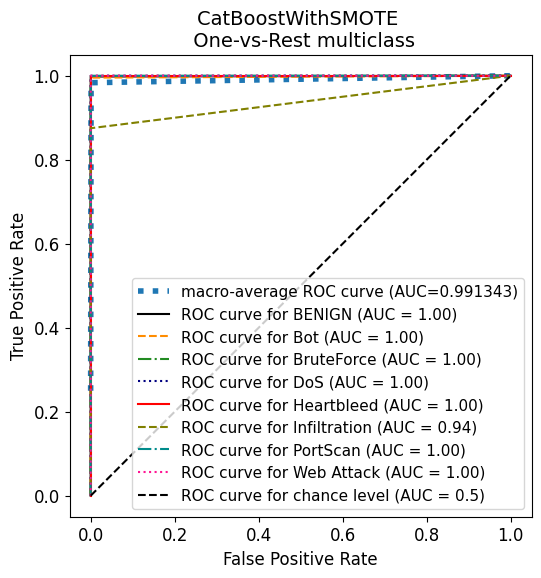

In [35]:
#6.3 Display
fig,ax=plt.subplots(figsize=(6,6))
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC={roc_auc['macro']:.6f})",
    linestyle=":",
    linewidth=4,
)
for i in range(num_class):
    RocCurveDisplay.from_predictions(
    y_test_en[:,i],
    y_pred_test_en[:,i],
    name=f"ROC curve for {class_names[i]}",
    color=colors[i],
    linestyle=linestyles[i],
    ax=ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("False Positive Rate",fontsize=12)
plt.ylabel("True Positive Rate",fontsize=12)
plt.title("CatBoostWithSMOTE \n One-vs-Rest multiclass",fontsize=14)
plt.legend(fontsize=11)
plt.show()

### Random Forest With Original Data   
Accuracy Score =  0.9103102912538195   
Precison       =  0.9684073872067926   
Recall         =  0.9103102912538195   
F1_score       =  0.9340837954082126   
Auc score      =  0.9548073632993797   

### Weight Metrics   
Accuracy Score     : 0.9985189444112895   
Weighted Precision : 0.99850615428196   
Weighted Recall    : 0.9985189444112895   
Weighted F1-score  : 0.9985091535241425   

### Random Forest With SMOTE   
Accuracy Score =  0.9563704217494868   
Precison       =  0.9549066052533266   
Recall         =  0.9563704217494868   
F1_score       =  0.9506837090876916   
Auc score      =  0.9779754647818648

### Weight Metrics After SMOTE   
Accuracy Score     : 0.9985759547410761   
Weighted Precision : 0.998684046700059   
Weighted Recall    : 0.9985759547410761   
Weighted F1-score  : 0.9986116272645491   

### CatBoost With Original Data  
Accuracy Score =  0.9336474366337519  
Precison       =  0.9837375280939686  
Recall         =  0.9336474366337519  
F1_score       =  0.9555094493490739  
Auc score      =  0.9666818721003482  

### Weighted Metrics
Accuracy Score : 0.9990635750086122
Weighted Precision : 0.9990537650619968
Weighted Recall : 0.9990635750086122
Weighted F1-score : 0.9990511323114969

### CatBoost With SMOTE  
Accuracy Score =  0.9834205843500247  
Precison       =  0.911111973463963  
Recall         =  0.9834205843500247  
F1_score       =  0.9366340995285412  
Auc score      =  0.9916013072331797  

In [36]:
###  Weighted Metrics
Accuracy Score     : 0.9984316094379995
Weighted Precision : 0.9988458646460229
Weighted Recall    : 0.9984316094379995
Weighted F1-score  : 0.9985691110364114

SyntaxError: invalid syntax (2747440689.py, line 2)